#In this problem, first, we want to implement a baseline neural network classification model, and then improve it.
write your code in the provided area.

# Importing required packages

In [ ]:
#401102191
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the Fashion MNIST dataset from torchvision package

In [4]:
#Your code
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',  # Directory to save the data
    train=True,     # Use training set
    download=True,  # Download if not already present
    transform=transform  # Apply transformations
)

# Load test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)
#Your code

100%|██████████| 26421880/26421880 [00:01<00:00, 13352648.00it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211237.48it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3874960.14it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10861306.33it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Split dataset into train, validation, and test sets(80 percent for training dataset)

In [5]:
#Your code
train_size = int(0.8*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_data = random_split(train_dataset, [train_size, val_size])
#Your code

# Create Data loaders for training, validation, and test sets.

In [6]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset, 
    shuffle=True,     # Shuffle training data
    batch_size=64,    # 64 samples per batch
    num_workers=2     # Use 2 worker processes for data loading
)

val_loader = DataLoader(
    val_data, 
    shuffle=False,    # No shuffling for validation
    batch_size=64,    # 64 samples per batch
    num_workers=2     # Use 2 worker processes for data loading
)

test_loader = DataLoader(
    test_dataset, 
    shuffle=False,    # No shuffling for test data
    batch_size=64,    # 64 samples per batch
    num_workers=2     # Use 2 worker processes for data loading
)

# Visualize some samples from each each class

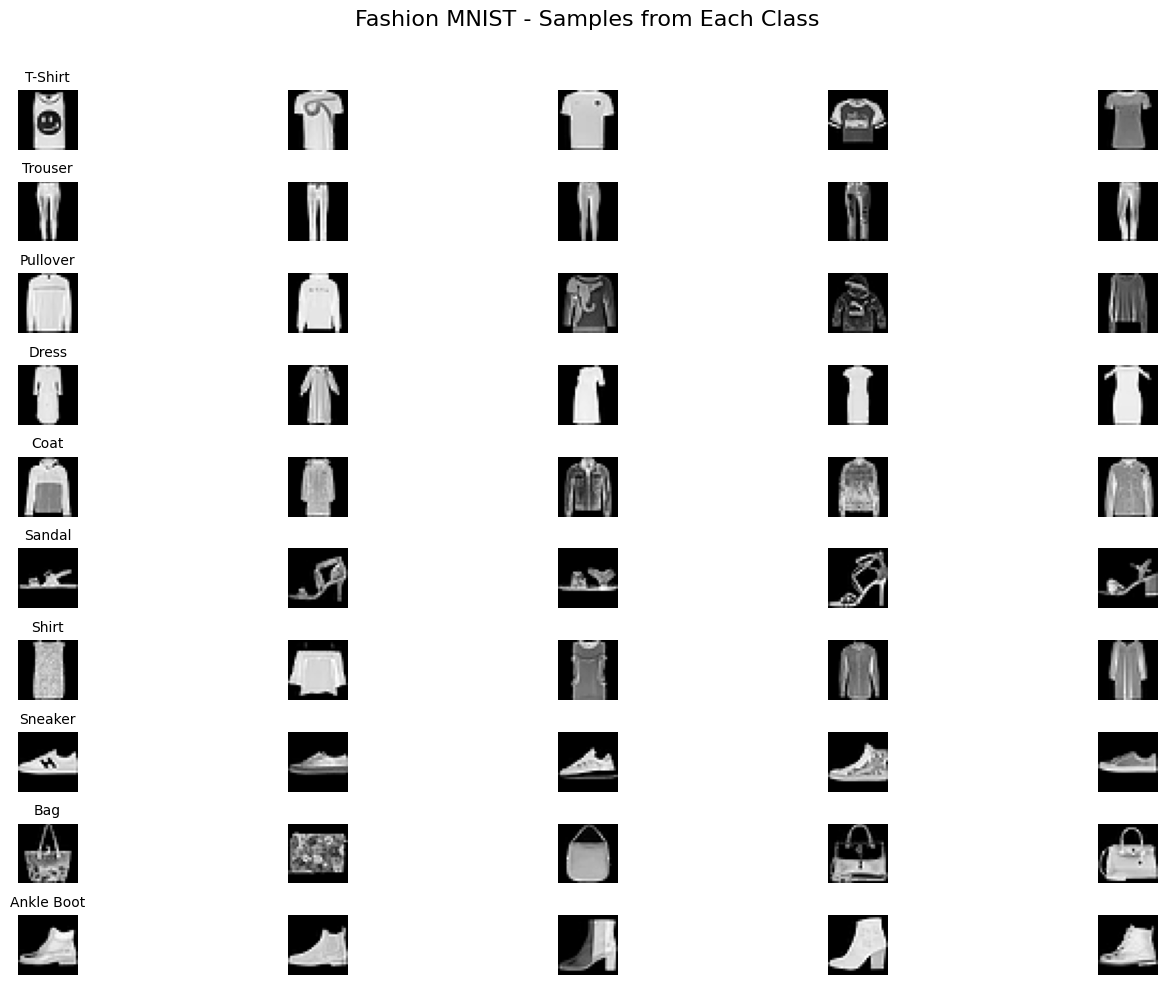

In [7]:
#Your code
# Class labels for Fashion MNIST
CLASS_LABELS = [
    'T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
]

def visualize_class_samples(dataset, num_samples_per_class=5):
    plt.figure(figsize=(15, 10))
    class_samples = {i: 0 for i in range(len(CLASS_LABELS))}
    for img, label in dataset:
        if class_samples[label] < num_samples_per_class:
            pos = label * num_samples_per_class + class_samples[label] + 1
            image = img.squeeze().numpy()
            image = (image * 0.5) + 0.5  # Reverse normalization
            plt.subplot(len(CLASS_LABELS), num_samples_per_class, pos)
            plt.imshow(image, cmap='gray')
            if class_samples[label] == 0:
                plt.title(CLASS_LABELS[label], fontsize=10)
            
            plt.axis('off')
            class_samples[label] += 1
        
        if all(count == num_samples_per_class for count in class_samples.values()):
            break
    plt.tight_layout()
    plt.suptitle('Fashion MNIST - Samples from Each Class', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()
visualize_class_samples(train_dataset)
#Your code

# Define a simple neural network (MLP) without convolution layers

In [8]:
class ReLUModel(nn.Module):
    def __init__(self):
        super(ReLUModel, self).__init__()
       
        # Flatten layer to convert 2D image to 1D vector
        self.flatten = nn.Flatten()
        
        # Fully connected layers with ReLU activations
        self.fc1 = nn.Linear(784, 512)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        
        self.fc5 = nn.Linear(64, 10)
        
        # Note: Softmax is typically applied in the loss function, 
        # not in the model's forward pass for training
        # self.softmax = nn.Softmax(dim=1)  # Commented out

    def forward(self, x):
        # Flatten the input image
        x = self.flatten(x)
        
        # Pass through layers with ReLU activations
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        
        # Final output layer (without activation)
        x = self.fc5(x)
        
        # Note: Softmax is not applied here for training
        # During training, use CrossEntropyLoss which applies softmax internally
        return x
    #Your code
class TanhModel(nn.Module):

    def __init__(self):
        super(TanhModel, self).__init__()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(512, 256)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(256, 128)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(128, 64)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        x = self.tanh3(x)
        x = self.fc4(x)
        x = self.tanh4(x)
        x = self.fc5(x)
        x = self.softmax(x)

        return x
        
#Your code

# Define your loss function, and optimizer

In [9]:
#Your code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
relu_model = ReLUModel().to(device)
tanh_model = TanhModel().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
relu_optimizer = optim.Adam(relu_model.parameters(), lr=0.001)
tanh_optimizer = optim.Adam(tanh_model.parameters(), lr=0.001)

#Your code

#Train two models: one using the ReLU activation function and the other using the Tanh activation function, while keeping all other parameters the same. Finally, report the accuracies on the test dataset.

#In one figure, plot the loss over epochs for both the training and validation sets. In a separate figure, plot the accuracy over epochs for the training and validation sets for both models.(At the end, you should have 4 figures)

#How do the models differ in terms of performance?


Convergence Speed: ReLU might converge faster in some cases due to its simpler computation.
Stability: Tanh might lead to more stable training, especially in deeper networks, as it provides a smoother gradient.
Performance: The best-performing model will depend on the specific dataset and network architecture.


Training ReLU Model:
Epoch [1/20], Train Loss: 0.5534, Val Loss: 0.4010, Train Acc: 79.66%, Val Acc: 85.68%
Epoch [2/20], Train Loss: 0.3968, Val Loss: 0.3960, Train Acc: 85.32%, Val Acc: 86.22%
Epoch [3/20], Train Loss: 0.3562, Val Loss: 0.3383, Train Acc: 86.74%, Val Acc: 87.87%
Epoch [4/20], Train Loss: 0.3279, Val Loss: 0.3565, Train Acc: 87.89%, Val Acc: 87.70%
Epoch [5/20], Train Loss: 0.3098, Val Loss: 0.3142, Train Acc: 88.63%, Val Acc: 88.94%
Epoch [6/20], Train Loss: 0.2899, Val Loss: 0.3425, Train Acc: 89.26%, Val Acc: 87.97%
Epoch [7/20], Train Loss: 0.2743, Val Loss: 0.3196, Train Acc: 89.76%, Val Acc: 88.76%
Epoch [8/20], Train Loss: 0.2563, Val Loss: 0.3131, Train Acc: 90.54%, Val Acc: 88.83%
Epoch [9/20], Train Loss: 0.2476, Val Loss: 0.3335, Train Acc: 90.90%, Val Acc: 88.40%
Epoch [10/20], Train Loss: 0.2349, Val Loss: 0.3554, Train Acc: 91.16%, Val Acc: 87.53%
Epoch [11/20], Train Loss: 0.2261, Val Loss: 0.3211, Train Acc: 91.57%, Val Acc: 88.72%
Epoch [12/20], Trai

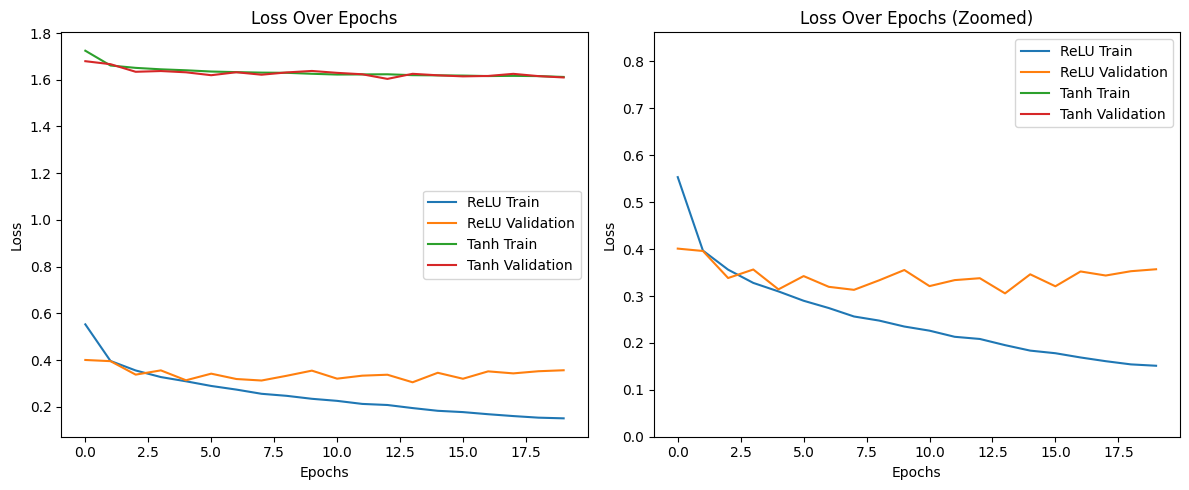

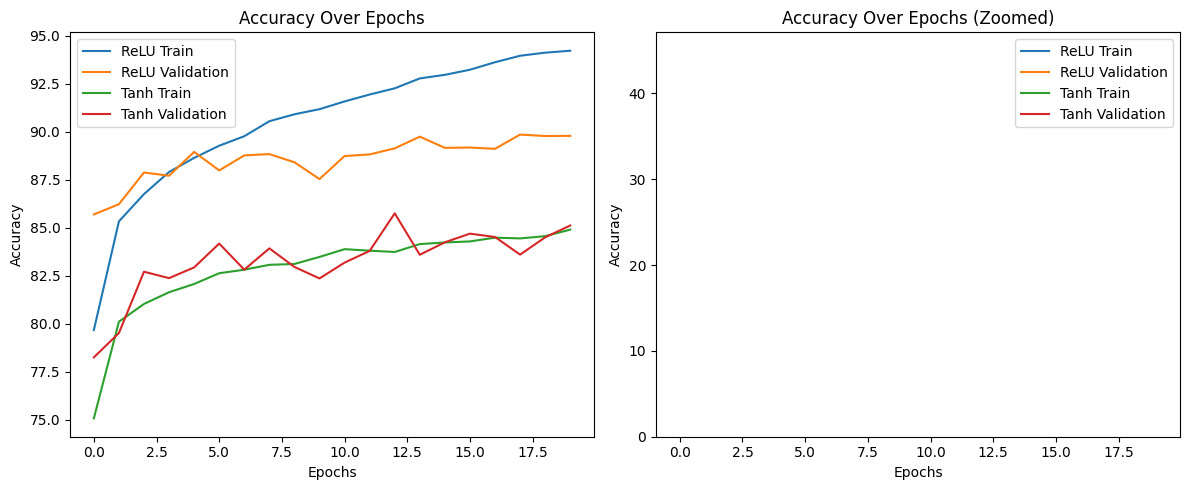

In [10]:
#Your code
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    # Tracking metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate training metrics
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Calculate validation metrics
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        # Store epoch metrics
        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        train_accuracy = 100 * correct_train / total_train
        val_accuracy = 100 * correct_val / total_val
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/20], '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy
def plot_metrics(relu_train, relu_val, tanh_train, tanh_val, metric_name):
    plt.figure(figsize=(12, 5))
    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(relu_train, label='ReLU Train')
    plt.plot(relu_val, label='ReLU Validation')
    plt.plot(tanh_train, label='Tanh Train')
    plt.plot(tanh_val, label='Tanh Validation')
    plt.title(f'{metric_name} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    
    # Zoom-in subplot
    plt.subplot(1, 2, 2)
    plt.plot(relu_train, label='ReLU Train')
    plt.plot(relu_val, label='ReLU Validation')
    plt.plot(tanh_train, label='Tanh Train')
    plt.plot(tanh_val, label='Tanh Validation')
    plt.title(f'{metric_name} Over Epochs (Zoomed)')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.ylim(0, max(max(relu_train), max(relu_val), max(tanh_train), max(tanh_val)) * 0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
# Train models
print("\nTraining ReLU Model:")
relu_train_losses, relu_val_losses, relu_train_accs, relu_val_accs = train_model(
    relu_model, train_loader, val_loader, criterion, relu_optimizer)
print("\nTraining Tanh Model:")
tanh_train_losses, tanh_val_losses, tanh_train_accs, tanh_val_accs = train_model(
    tanh_model, train_loader, val_loader, criterion, tanh_optimizer)
print("\nTest Set Evaluation:")
relu_test_accuracy = evaluate_model(relu_model, test_loader)
tanh_test_accuracy = evaluate_model(tanh_model, test_loader)
print(f"ReLU Model Test Accuracy: {relu_test_accuracy:.2f}%")
print(f"Tanh Model Test Accuracy: {tanh_test_accuracy:.2f}%")
plot_metrics(relu_train_losses, relu_val_losses, 
             tanh_train_losses, tanh_val_losses, 
             'Loss')
plot_metrics(relu_train_accs, relu_val_accs, 
             tanh_train_accs, tanh_val_accs, 
             'Accuracy')
#Your code

#What was the optimum number of epochs for training? why?

#Repeat all the previous sections, but this time, add some convolutional layers to your model.


Training ReLU CNN Model:
Epoch [1/20], Train Loss: 0.5611, Val Loss: 0.3236, Train Acc: 79.68%, Val Acc: 88.53%
Epoch [2/20], Train Loss: 0.3354, Val Loss: 0.2746, Train Acc: 88.06%, Val Acc: 90.01%
Epoch [3/20], Train Loss: 0.2831, Val Loss: 0.2523, Train Acc: 90.02%, Val Acc: 90.88%
Epoch [4/20], Train Loss: 0.2441, Val Loss: 0.2249, Train Acc: 91.30%, Val Acc: 92.17%
Epoch [5/20], Train Loss: 0.2181, Val Loss: 0.2183, Train Acc: 92.04%, Val Acc: 92.12%
Epoch [6/20], Train Loss: 0.1929, Val Loss: 0.2204, Train Acc: 92.92%, Val Acc: 92.42%
Epoch [7/20], Train Loss: 0.1730, Val Loss: 0.2207, Train Acc: 93.74%, Val Acc: 92.34%
Epoch [8/20], Train Loss: 0.1577, Val Loss: 0.2280, Train Acc: 94.41%, Val Acc: 91.93%
Epoch [9/20], Train Loss: 0.1448, Val Loss: 0.2395, Train Acc: 94.60%, Val Acc: 91.94%
Epoch [10/20], Train Loss: 0.1288, Val Loss: 0.2473, Train Acc: 95.29%, Val Acc: 92.23%
Epoch [11/20], Train Loss: 0.1192, Val Loss: 0.2454, Train Acc: 95.61%, Val Acc: 92.38%
Epoch [12/20], 

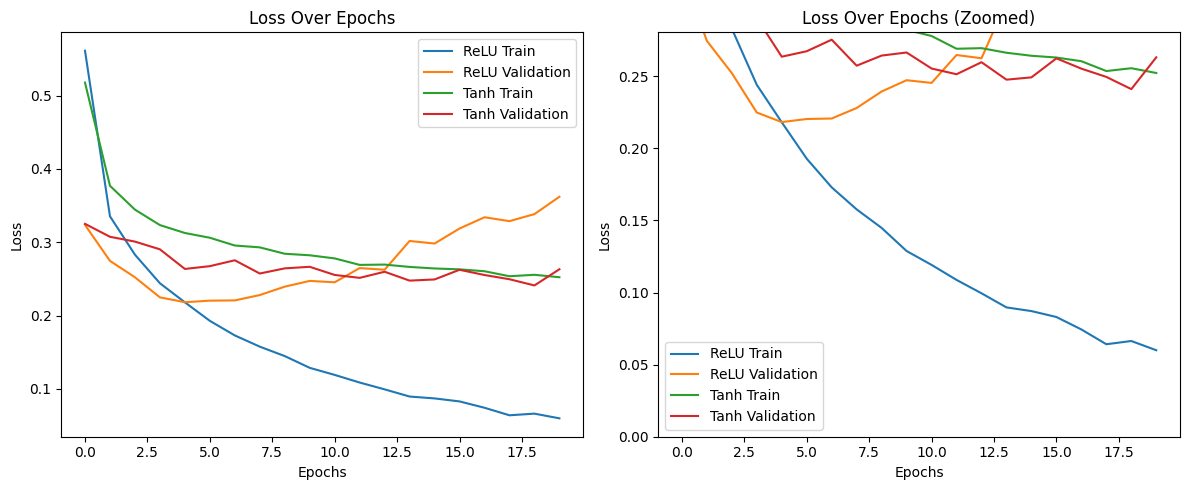

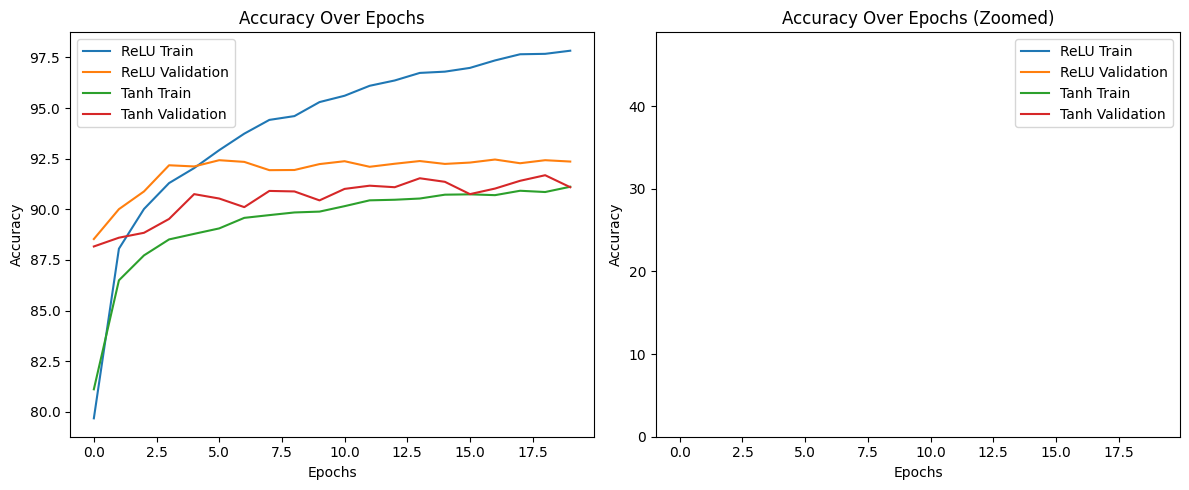

In [11]:
#Your code
# CNN Model with ReLU activation
class CNNReLUModel(nn.Module):
    def __init__(self):
        super(CNNReLUModel, self).__init__()
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolutional layer
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# CNN Model with Tanh activation
class CNNTanhModel(nn.Module):
    def __init__(self):
        super(CNNTanhModel, self).__init__()
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolutional layer
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Tanh()
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Training function (same as previous implementation)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    # Tracking metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate training metrics
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Calculate validation metrics
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        # Store epoch metrics
        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        train_accuracy = 100 * correct_train / total_train
        val_accuracy = 100 * correct_val / total_val
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/20], '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies
# Prepare models and training
relu_cnn_model = CNNReLUModel().to(device)
tanh_cnn_model = CNNTanhModel().to(device)
criterion = nn.CrossEntropyLoss()
relu_cnn_optimizer = optim.Adam(relu_cnn_model.parameters(), lr=0.001)
tanh_cnn_optimizer = optim.Adam(tanh_cnn_model.parameters(), lr=0.001)
# Train models
print("\nTraining ReLU CNN Model:")
relu_train_losses, relu_val_losses, relu_train_accs, relu_val_accs = train_model(
    relu_cnn_model, train_loader, val_loader, criterion, relu_cnn_optimizer)

print("\nTraining Tanh CNN Model:")
tanh_train_losses, tanh_val_losses, tanh_train_accs, tanh_val_accs = train_model(
    tanh_cnn_model, train_loader, val_loader, criterion, tanh_cnn_optimizer)

# Evaluate on test set
print("\nTest Set Evaluation:")
relu_cnn_test_accuracy = evaluate_model(relu_cnn_model, test_loader)
tanh_cnn_test_accuracy = evaluate_model(tanh_cnn_model, test_loader)
print(f"ReLU CNN Model Test Accuracy: {relu_cnn_test_accuracy:.2f}%")
print(f"Tanh CNN Model Test Accuracy: {tanh_cnn_test_accuracy:.2f}%")

# Plot loss and accuracy
plot_metrics(relu_train_losses, relu_val_losses, 
             tanh_train_losses, tanh_val_losses, 
             'Loss')
plot_metrics(relu_train_accs, relu_val_accs, 
             tanh_train_accs, tanh_val_accs, 
             'Accuracy')
#Your code

# How can we get to highr accuracy?

# First, define the max pooling and dropout techniques, and then use them in your model to enhance the accuracy.
1. Max Pooling
- Definition: Max pooling is a downsampling technique commonly used in convolutional neural networks (CNNs). It reduces the spatial dimensions of the feature maps while preserving the most important information.   
- How it Works: A max pooling layer divides the input feature map into non-overlapping rectangular regions. It then selects the maximum value from each region and outputs it as the result
2. Dropout
- Definition: Dropout is a regularization technique that randomly deactivates a fraction of neurons during training.
- How it Works: During each training iteration, a certain percentage of neurons are randomly selected and "dropped out," meaning their outputs are set to zero. The remaining neurons are trained as usual.
# Report the accuracies and plot the mentioned figures.
We added the maxpoolign and dropout techniques in the last part and saw the better accuracies.